In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 1. Data understanding and EDA

In [ ]:
data = pd.read_csv('/content/stock_price.csv')
data.columns = ['Date', 'Close', 'Open', 'High', 'Low', 'Volume', 'Change %']

# Convert 'Date' to datetime format for time-series analysis
data['Date'] = pd.to_datetime(data['Date'])

# Summary statistics
summary_stats = data.describe()

# Checking for missing values
missing_values = data.isnull().sum()

print(summary_stats)

                                Date        Close         Open         High  \
count                           9202  9202.000000  9202.000000  9202.000000   
mean   2005-10-21 08:44:04.642469248    92.180961    92.256183    93.176451   
min              1987-02-12 00:00:00    33.000000    33.000000    33.200000   
25%              1996-06-06 06:00:00    52.000000    52.100000    52.800000   
50%              2005-10-11 12:00:00    85.100000    85.100000    86.050000   
75%              2015-03-04 18:00:00   110.800000   110.800000   111.900000   
max              2024-08-01 00:00:00   305.900000   309.800000   311.800000   
std                              NaN    50.452228    50.598215    51.049837   

               Low  
count  9202.000000  
mean     91.330146  
min      32.200000  
25%      51.500000  
50%      84.200000  
75%     109.275000  
max     303.900000  
std      50.087405  


In [ ]:
print(missing_values)

Date        0
Close       0
Open        0
High        0
Low         0
Volume      0
Change %    0
dtype: int64


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


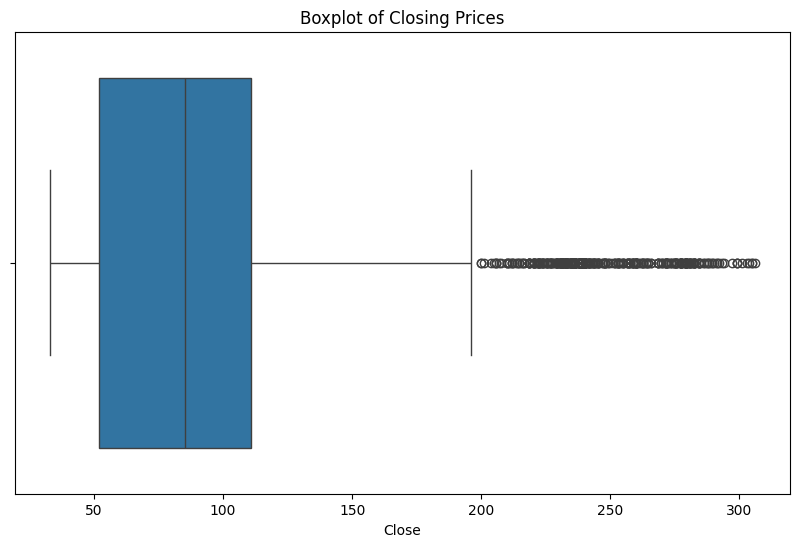

In [ ]:
# Detect outliers using boxplot
plt.figure(figsize=(10,6))
sns.boxplot(x=data['Close'])
plt.title('Boxplot of Closing Prices')
plt.show()

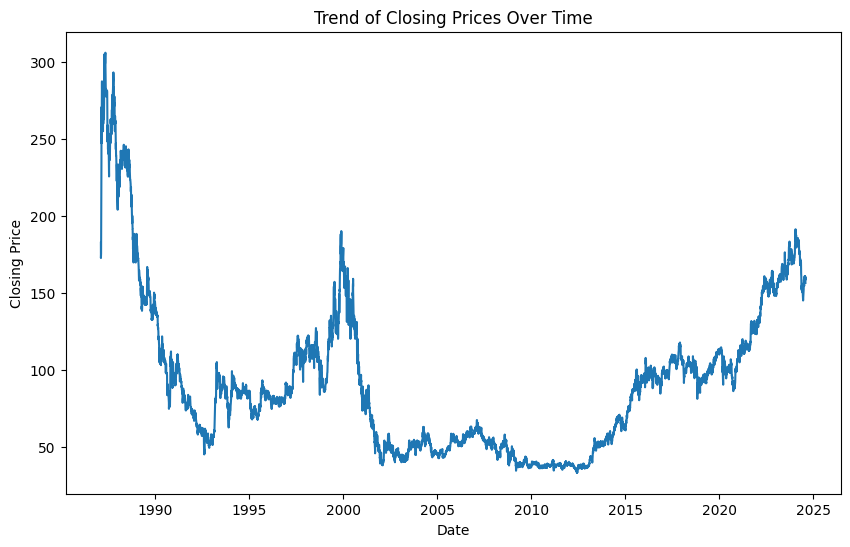

In [ ]:
# Time-series plot of closing price
plt.figure(figsize=(10,6))
plt.plot(data['Date'], data['Close'])
plt.title('Trend of Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

# Checking for seasonality using rolling mean (e.g., 30-day window)
data['Rolling_Mean'] = data['Close'].rolling(window=30).mean()

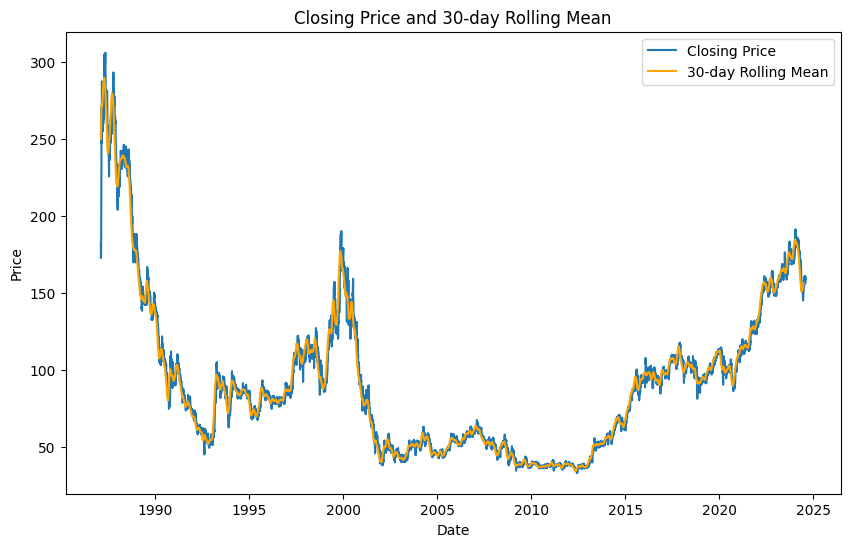

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(data['Date'], data['Close'], label='Closing Price')
plt.plot(data['Date'], data['Rolling_Mean'], label='30-day Rolling Mean', color='orange')
plt.title('Closing Price and 30-day Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
data

,Date,Close,Open,High,Low,Volume,Change %,Rolling_Mean
0,2024-08-01,156.3,159.3,159.4,156.1,79.15M,-2.56%,NaN
1,2024-07-31,160.4,158.2,160.7,158.1,173.91M,1.07%,NaN
2,2024-07-30,158.7,158.8,159.2,158.0,138.14M,-0.63%,NaN
3,2024-07-29,159.7,158.7,160.2,158.4,126.28M,1.14%,NaN
4,2024-07-26,157.9,159.3,159.6,157.9,155.08M,-0.13%,NaN
...,...,...,...,...,...,...,...,...
9197,1987-02-18,191.2,186.3,191.2,186.3,795.09M,4.82%,261.573333
9198,1987-02-17,182.4,176.5,184.3,175.5,881.51M,3.93%,258.796667
9199,1987-02-16,175.5,166.7,175.5,165.7,360.51M,1.74%,255.986667
9200,1987-02-13,172.5,176.5,176.5,172.5,422.38M,-5.43%,252.586667


# 2. Data Preprocessing and Feature Engineering

In [ ]:
# Function to convert volume to numeric by handling 'M' and 'B'
def convert_volume(volume):
    if 'M' in volume:
        return float(volume.replace('M', '')) * 1e6
    elif 'B' in volume:
        return float(volume.replace('B', '')) * 1e9
    else:
        return float(volume)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Apply the function to the 'Volume' column
data['Volume'] = data['Volume'].apply(convert_volume)

# Feature Engineering: Creating new features like price change, moving averages, etc.
data['Price_Change'] = data['Close'].diff()
data['High_Low_Spread'] = data['High'] - data['Low']

# Dropping rows with missing values after creating diff
data.dropna(inplace=True)

# Scaling the features using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Close', 'Open',	'High',	'Low',	'Volume', 'Price_Change', 'High_Low_Spread']])

scaled_df = pd.DataFrame(scaled_data, columns=['Close', 'Open',	'High',	'Low',	'Volume', 'Price_Change', 'High_Low_Spread'])

scaled_df.head()


,Close,Open,High,Low,Volume,Price_Change,High_Low_Spread
0,0.414071,0.407153,0.407035,0.416268,0.129720,0.564145,0.055319
1,0.412605,0.406431,0.404164,0.412955,0.149615,0.574013,0.059574
2,0.412239,0.401012,0.406317,0.411483,0.141021,0.578947,0.102128
3,0.410040,0.405347,0.406676,0.413324,0.176971,0.570724,0.085106
4,0.415903,0.408237,0.408112,0.416636,0.324178,0.606908,0.063830


# 3. Model Selection and Training

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split


# Preparing the data for LSTM
X = []
y = []

# Assuming we are predicting the next closing price based on the last 60 days
time_steps = 60
for i in range(time_steps, len(scaled_df)):
    X.append(scaled_df.iloc[i-time_steps:i].values)
    y.append(scaled_df.iloc[i, 0])  # Closing price is the target

X, y = np.array(X), np.array(y)

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initializing the Sequential model
model = Sequential()

# Adding a 1D CNN layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))

# Adding another CNN layer (optional, can be skipped)
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Passing the 3D output directly to the LSTM (No Flatten)
model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
model.add(Dropout(0.2))

# Adding another Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=50, return_sequences=False)))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units=1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Summary of the model
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 58, 64)              │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 27, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 13, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 13, 100)             │          46,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 13, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 100)                 │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,261 (469.77 KB)

 Trainable params: 120,261 (469.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.0042 - mae: 0.0387
Epoch 2/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 7.0171e-04 - mae: 0.0187
Epoch 3/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 5.7858e-04 - mae: 0.0172
Epoch 4/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 4.6781e-04 - mae: 0.0156
Epoch 5/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 4.5306e-04 - mae: 0.0152
Epoch 6/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 4.3185e-04 - mae: 0.0148
Epoch 7/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 4.5310e-04 - mae: 0.0153
Epoch 8/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 3.8699e-04 - mae: 0.0141
Epoch 9/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 3.2957e-04 - mae: 0.0131
Epoch 10/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 3.3632e-04 - mae: 0.0130
Epoch 11/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 3.1751e-04 - mae: 0.0127
Epoch 12/20
228/228 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step -

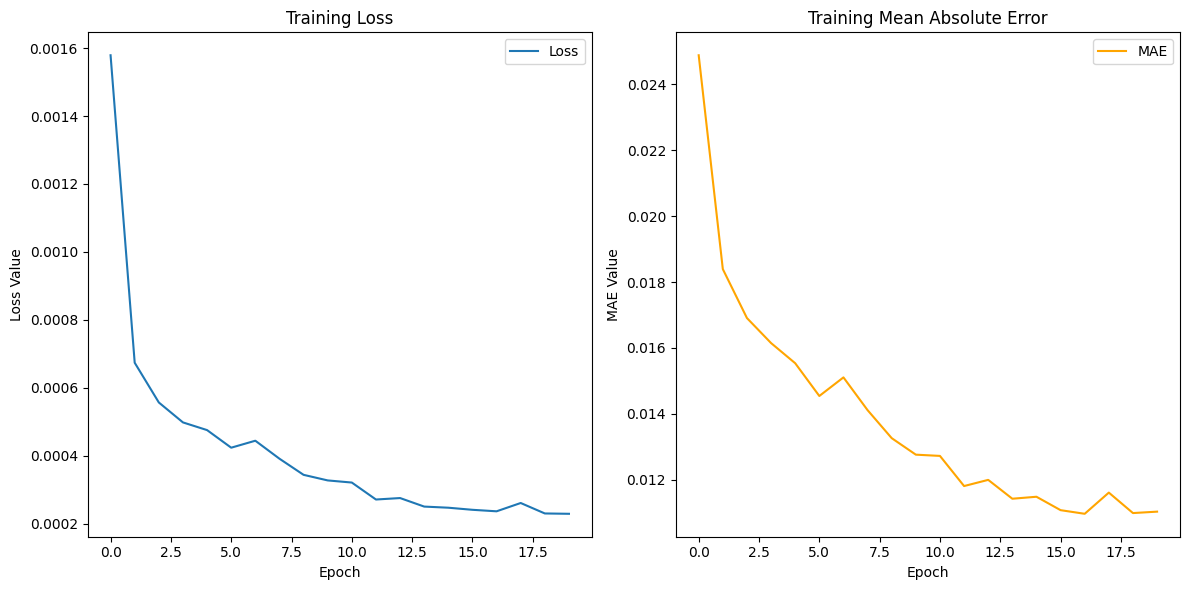

In [ ]:
# Create a figure and two subplots (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the loss on the first subplot
ax1.plot(history.history['loss'], label='Loss')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss Value')
ax1.legend()

# Plotting the MAE on the second subplot
ax2.plot(history.history['mae'], label='MAE', color='orange')
ax2.set_title('Training Mean Absolute Error')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE Value')
ax2.legend()

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()


# 4. Model Evaluation and Results Analysis

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Predictions on the test set
y_pred = model.predict(X_test)

# Rescale the predictions back to original scale
y_pred_rescaled = scaler.inverse_transform(np.concatenate([y_pred, np.zeros((y_pred.shape[0], 6))], axis=1))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 6))], axis=1))[:, 0]

# Calculate evaluation metrics
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Percentage Error: {mape}')

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Mean Squared Error: 180.12967772597395
Mean Absolute Percentage Error: 0.051632463105379854


# 5. Consider improvement measures and retrain the model

In [ ]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, Bidirectional
from keras.models import Model, Sequential

# Initializing the Sequential model
model = Sequential()

# Adding the first Bidirectional LSTM layer with dropout
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Adding another Bidirectional LSTM layer without `return_sequences` (since it's the last LSTM layer)
model.add(Bidirectional(LSTM(units=50, return_sequences=False)))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units=1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Summary of the model
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional)      │ (None, 60, 100)             │          23,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 100)                 │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,701 (326.96 KB)

 Trainable params: 83,701 (326.96 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0067 - mae: 0.0492
Epoch 2/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 5.1168e-04 - mae: 0.0163
Epoch 3/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 4.4981e-04 - mae: 0.0152
Epoch 4/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 3.7386e-04 - mae: 0.0137
Epoch 5/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 3.2591e-04 - mae: 0.0130
Epoch 6/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 3.0259e-04 - mae: 0.0126
Epoch 7/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 3.0417e-04 - mae: 0.0127
Epoch 8/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 2.6923e-04 - mae: 0.0117
Epoch 9/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 2.6553e-04 - mae: 0.0116
Epoch 10/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 2.4386e-04 - mae: 0.0111
Epoch 11/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.4196e-04 - mae: 0.0109
Epoch 12/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - 

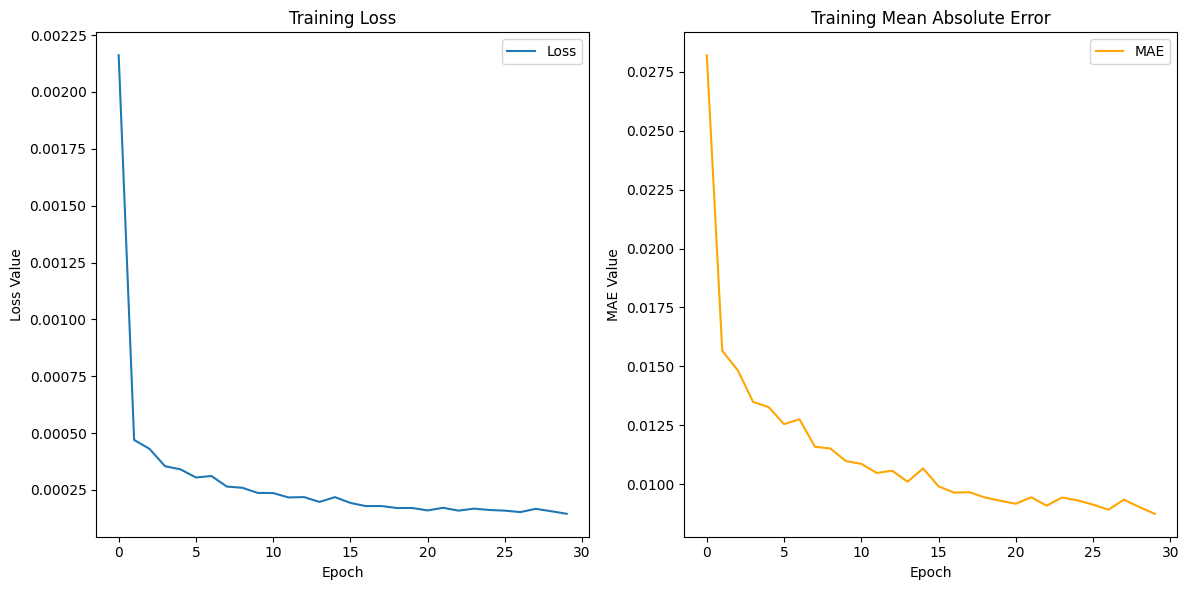

In [ ]:
# Create a figure and two subplots (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the loss on the first subplot
ax1.plot(history.history['loss'], label='Loss')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss Value')
ax1.legend()

# Plotting the MAE on the second subplot
ax2.plot(history.history['mae'], label='MAE', color='orange')
ax2.set_title('Training Mean Absolute Error')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE Value')
ax2.legend()

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Predictions on the test set
y_pred = model.predict(X_test)

# Rescale the predictions back to original scale
y_pred_rescaled = scaler.inverse_transform(np.concatenate([y_pred, np.zeros((y_pred.shape[0], 6))], axis=1))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 6))], axis=1))[:, 0]

# Calculate evaluation metrics
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Percentage Error: {mape}')

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Mean Squared Error: 10.807013218509296
Mean Absolute Percentage Error: 0.017558261747711808


# Hypothesis 1: Adding more lagged features give better results

In [ ]:
# Preparing the data for LSTM
X = []
y = []

# Assuming we are predicting the next closing price based on the last 60 days
time_steps = 5
for i in range(time_steps, len(scaled_df)):
    X.append(scaled_df.iloc[i-time_steps:i].values)
    y.append(scaled_df.iloc[i, 0])  # Closing price is the target

X, y = np.array(X), np.array(y)

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initializing the Sequential model
model = Sequential()

# Adding the first Bidirectional LSTM layer with dropout
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Adding another Bidirectional LSTM layer without `return_sequences` (since it's the last LSTM layer)
model.add(Bidirectional(LSTM(units=50, return_sequences=False)))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units=1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Summary of the model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional)      │ (None, 5, 100)              │          23,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 5, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 100)                 │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,701 (326.96 KB)

 Trainable params: 83,701 (326.96 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0052 - mae: 0.0399
Epoch 2/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.6683e-04 - mae: 0.0141
Epoch 3/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.9633e-04 - mae: 0.0124
Epoch 4/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.9742e-04 - mae: 0.0120
Epoch 5/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.4253e-04 - mae: 0.0109
Epoch 6/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.1169e-04 - mae: 0.0104
Epoch 7/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.3102e-04 - mae: 0.0104
Epoch 8/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.0876e-04 - mae: 0.0102
Epoch 9/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.8300e-04 - mae: 0.0093
Epoch 10/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.7930e-04 - mae: 0.0093
Epoch 11/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.5509e-04 - mae: 0.0089
Epoch 12/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.

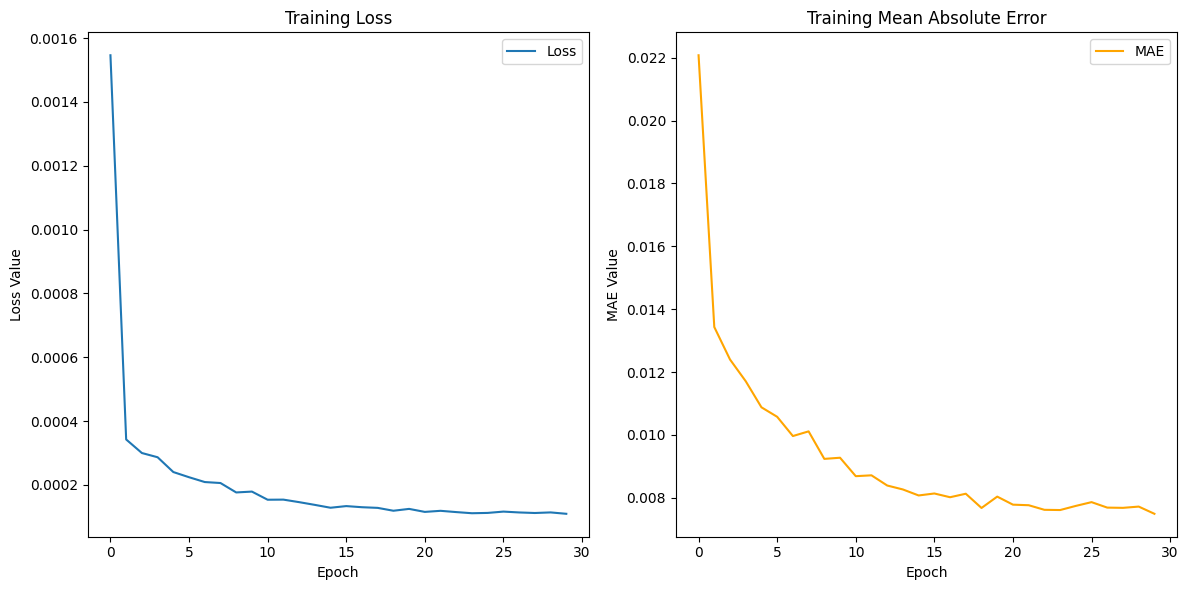

In [ ]:
# Create a figure and two subplots (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the loss on the first subplot
ax1.plot(history.history['loss'], label='Loss')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss Value')
ax1.legend()

# Plotting the MAE on the second subplot
ax2.plot(history.history['mae'], label='MAE', color='orange')
ax2.set_title('Training Mean Absolute Error')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE Value')
ax2.legend()

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Predictions on the test set
y_pred = model.predict(X_test)

# Rescale the predictions back to original scale
y_pred_rescaled = scaler.inverse_transform(np.concatenate([y_pred, np.zeros((y_pred.shape[0], 6))], axis=1))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 6))], axis=1))[:, 0]

# Calculate evaluation metrics
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Percentage Error: {mape}')

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Mean Squared Error: 46.84152994287444
Mean Absolute Percentage Error: 0.02275797919361384


 *   When the number of lagging days was 60, the testing error was lower compared to the model using a lagging day of 5, although the training error was lesser in the latter.
 *   This shows that having higher number of lagging features gives Better results.

**Therfore the Hypothesis 1 is verified**

# Hypothesis 2: Incorporating moving averages and other technical indicators (e.g. MACD) can help capture market trends and improve predictions.

In [ ]:
# Moving Average Convergence Divergence (MACD)
data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()  # 12-day EMA
data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()  # 26-day EMA
data['MACD'] = data['EMA_12'] - data['EMA_26']

# Drop rows with NaN values that were created by rolling calculations
data.dropna(inplace=True)

The MACD was developed by Gerald Appel in the late 1970s, and the parameters he chose (12 and 26) have become widely accepted standards in the trading community. So I have chosen the same.

In [ ]:
# Scaling the features using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Close', 'Open',	'High',	'Low',	'Volume', 'Price_Change', 'High_Low_Spread', 'EMA_12', 'EMA_26', 'MACD']])

scaled_df = pd.DataFrame(scaled_data, columns=['Close', 'Open',	'High',	'Low',	'Volume', 'Price_Change', 'High_Low_Spread', 'EMA_12', 'EMA_26', 'MACD'])

scaled_df.head()

,Close,Open,High,Low,Volume,Price_Change,High_Low_Spread,EMA_12,EMA_26,MACD
0,0.414071,0.407153,0.407035,0.416268,0.129720,0.564145,0.055319,0.426870,0.435017,0.722666
1,0.412605,0.406431,0.404164,0.412955,0.149615,0.574013,0.059574,0.426636,0.434901,0.721758
2,0.412239,0.401012,0.406317,0.411483,0.141021,0.578947,0.102128,0.426380,0.434766,0.720830
3,0.410040,0.405347,0.406676,0.413324,0.176971,0.570724,0.085106,0.425813,0.434467,0.718763
4,0.415903,0.408237,0.408112,0.416636,0.324178,0.606908,0.063830,0.426268,0.434652,0.720818


In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
# Preparing the data for LSTM
X = []
y = []

# Assuming we are predicting the next closing price based on the last 60 days
time_steps = 60
for i in range(time_steps, len(scaled_df)):
    X.append(scaled_df.iloc[i-time_steps:i].values)
    y.append(scaled_df.iloc[i, 0])  # Closing price is the target

X, y = np.array(X), np.array(y)

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# Initializing the Sequential model
model = Sequential()

# Adding the first Bidirectional LSTM layer with dropout
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Adding another Bidirectional LSTM layer without `return_sequences` (since it's the last LSTM layer)
model.add(Bidirectional(LSTM(units=50, return_sequences=False)))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units=1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Summary of the model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 60, 100)             │          24,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 100)                 │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 84,901 (331.64 KB)

 Trainable params: 84,901 (331.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.0036 - mae: 0.0388
Epoch 2/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 5.2780e-04 - mae: 0.0173
Epoch 3/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 4.6221e-04 - mae: 0.0158
Epoch 4/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 3.7825e-04 - mae: 0.0145
Epoch 5/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 3.1900e-04 - mae: 0.0130
Epoch 6/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 2.9001e-04 - mae: 0.0122
Epoch 7/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 2.7447e-04 - mae: 0.0119
Epoch 8/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 2.3219e-04 - mae: 0.0108
Epoch 9/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 2.0781e-04 - mae: 0.0105
Epoch 10/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 2.0966e-04 - mae: 0.0105
Epoch 11/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 2.0497e-04 - mae: 0.0102
Epoch 12/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step -

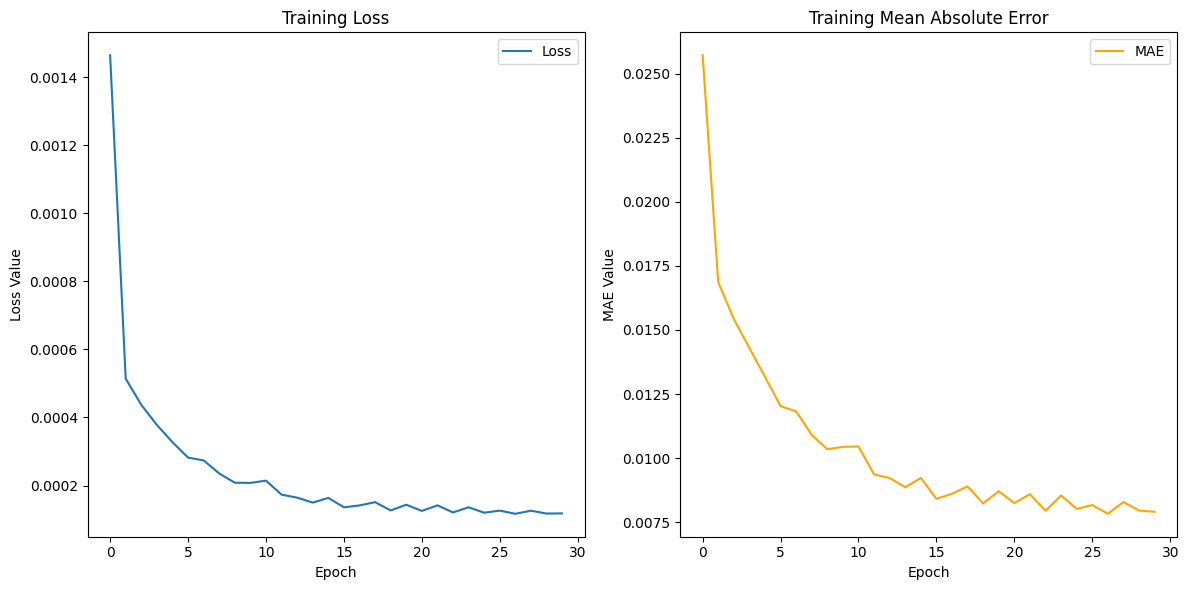

In [ ]:
# Create a figure and two subplots (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the loss on the first subplot
ax1.plot(history.history['loss'], label='Loss')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss Value')
ax1.legend()

# Plotting the MAE on the second subplot
ax2.plot(history.history['mae'], label='MAE', color='orange')
ax2.set_title('Training Mean Absolute Error')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE Value')
ax2.legend()

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Predictions on the test set
y_pred = model.predict(X_test)

# Rescale the predictions back to original scale
y_pred_rescaled = scaler.inverse_transform(np.concatenate([y_pred, np.zeros((y_pred.shape[0], 9))], axis=1))[:, 0]
y_test_rescaled = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 9))], axis=1))[:, 0]

# Calculate evaluation metrics
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Percentage Error: {mape}')

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Mean Squared Error: 21.453125888391416
Mean Absolute Percentage Error: 0.02269671926403816


 *   When the MACD was added it was expected to perform better, but it didn't
 *   This might be due to the fact that the existing features were good enough to predict the stick price or becuase the new features were.

**Therefore the Hypothesis 2 failed**